In [1]:
%matplotlib inline

import numpy as np
import os
import sys
import tensorflow as tf


from distutils.version import StrictVersion
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ImageDraw as ImageDraw

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [2]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03' + '/frozen_inference_graph.pb'


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [3]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,image_width):
  """Transforms the box masks back to full image masks.

  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.

  Args:
    box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.

  Returns:
    A tf.float32 tensor of size [num_masks, image_height, image_width].
  """
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    return tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_ind=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        extrapolation_value=0.0)
  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
  return tf.squeeze(image_masks, axis=3)


In [4]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [5]:
def draw_image_and_bounding_box(image_path,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color='red',
                                       thickness=4,
                                       use_normalized_coordinates=True):
    """Adds a bounding box to an image.

    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.

    Args:
    image: a numpy representation of the image
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
    """
    
    image_pil = Image.open(image_path)
    image_np = np.asarray(image_pil).copy()
    
    draw = ImageDraw.Draw(image_pil)

    # Isolate image dimension
    im_width, im_height = image_pil.size
    
    
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)


    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=thickness, fill=color)
    
    
    np.copyto(image_np, np.array(image_pil))


    plt.figure(figsize=(9,12))
    plt.imshow(image_np)

In [6]:
def predict_bbox(image_path):
    # Get the image as a Pil.object
    image = Image.open(image_path)
    
    # Get its width and height
    (im_width, im_height) = image.size
    
    # Get its np representation
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection step
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    
    # Get bounding boxes that relate to cars
    car_bounding_boxes = output_dict["detection_boxes"][output_dict["detection_classes"] == 3]

    def calculate_area(bounding_box):
        ymin,xmin, ymax,xmax = bounding_box
        area = (ymax - ymin)*(xmax - xmin)
        return area

    # Get bounding box with the largest area
    best_bounding_box_index = np.array([(calculate_area(car_bounding_box)) for car_bounding_box in car_bounding_boxes]).argmax()
    best_bounding_box = output_dict["detection_boxes"][best_bounding_box_index]

    return best_bounding_box
    

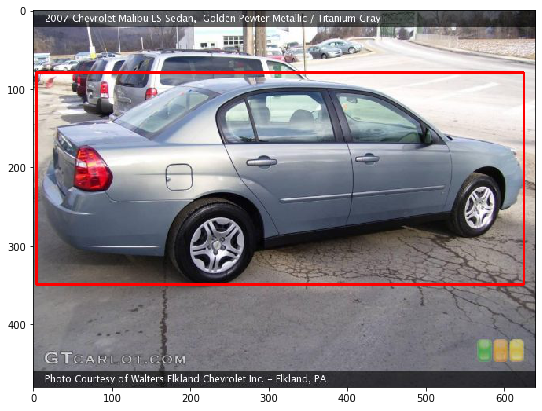

In [7]:
image_path = './test_images/00161.jpg'


(ymin,xmin, ymax,xmax) = predict_bbox(image_path)

draw_image_and_bounding_box(image_path,
                                  ymin,
                                  xmin, 
                                  ymax,
                                  xmax,
                                  thickness = 3)